In [4]:
import random
import torch

words = open('names.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness， sorted for reproducibility
random.seed(42)
random.shuffle(words)

chs = list(set(''.join(words + ['.'])))
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous tokens
block_size = 8
X, Y = [], []

for w in words:
    context = '.' * block_size
    for ch in w + '.':
        x = [stoi[c] for c in context]
        y = stoi[ch]
        X.append(x)
        Y.append(y)
        context = context[1:] + ch

X = torch.tensor(X)
Y = torch.tensor(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


(torch.Size([169062, 8]),
 torch.Size([21133, 8]),
 torch.Size([21133, 8]),
 torch.Size([169062]),
 torch.Size([21133]),
 torch.Size([21133]))

# play with MLP from tiny_torch

In [5]:
from tiny_torch import *

class MLP(Module):
    def __init__(self, vocab_size, block_size, n_embd, n_hidden, n_layer, dtype=torch.float64, generator=None):
        layers = [Embedding(vocab_size, n_embd, dtype=dtype, generator=generator), Flatten(), Linear(n_embd * block_size, n_hidden, bias=False, dtype=dtype, generator=generator), BatchNorm1d(n_hidden, dtype=dtype), Tanh()]
        for _ in range(n_layer-2):
            layers.extend([Linear(n_hidden, n_hidden, bias=False, dtype=dtype, generator=generator), BatchNorm1d(n_hidden, dtype=dtype), Tanh()])
        layers.extend([Linear(n_hidden, vocab_size, bias=False, dtype=dtype, generator=generator),])
        layers[-1].weight.data *= 0.1
        self.net = Sequential(layers)
        self.block_size = block_size

    def parameters(self):
        return self.net.parameters()
    
    def grads(self):
        return self.net.grads()

    def __call__(self, x):
        return self.net(x)

    def backward(self, grad):
        grad = self.net.backward(grad)
        return grad # None
    
    def eval(self):
        for l in self.net.layers:
            l._training = False

    def train(self):
        for l in self.net.layers:
            l._training = True

    def generate(self, s, max_new_tokens, do_sample=True, temperature=1.0):
        assert isinstance(s, str), 'str in, str out'
        assert len(s) == self.block_size, 'input string length must be equal to block size'
        x = torch.tensor([[stoi[ch] for ch in s]])
        for _ in range(max_new_tokens):
            cond = x[:, -self.block_size:]
            logits = self(cond) * (1 / temperature)
            probs = logits.softmax(dim=-1)
            if do_sample:
                next_x = torch.multinomial(probs, num_samples=1)
            else:
                next_x = probs.argmax(dim=-1, keepdim=True)
            x = torch.cat([x, next_x], dim=-1)
            if next_x.item() == 0:
                break
        s = ''.join([itos[idx.item()] for idx in x[0]])
        return s



In [6]:
n_embd = 10
n_hidden = 200
vocab_size = 27
n_layer = 2
dtype = torch.float64
eval_interval = 10000
bs = 32
n_steps = 200000
ini_lr = 0.1
lossis = []

# model
torch.manual_seed(42)
g = torch.Generator().manual_seed(42)
model = MLP(vocab_size, block_size, n_embd, n_hidden, n_layer, dtype)
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, ini_lr)


model.train()
for step in range(n_steps):
    lr = ini_lr if step < int(n_steps * 0.75) else ini_lr / 10
    optimizer.lr = lr
    idx = torch.randint(0, X_train.shape[0], (bs,), generator=g)
    x, y = X_train[idx], Y_train[idx]

    # forward
    logits = model(x)
    loss = loss_fn(logits, y)

    # backward
    # since grad buffer is stored in model class, we need to call backward imediately after forward
    # otherwise, grad buffer will be overwritten by next forward
    h_grad = loss_fn.backward(grad=1.0) # last layer, dloss=1.0
    model.backward(h_grad)
    
    # update
    optimizer.step()
    optimizer.zero_grad()

    # eval
    if step % eval_interval == 0: 
        model.eval()
        x, y = X_val, Y_val
        logits = model(x)
        val_loss = loss_fn(logits, y) # val loss is actually one step later than train loss
        print(f'step: {step}, train loss: {loss.item()}, val loss: {val_loss.item()}')
        model.train()
    lossis.append(loss.log10().item())
    

step: 0, train loss: 3.3093357003530555, val loss: 3.293087279158654
step: 10000, train loss: 2.191763784254482, val loss: 2.2093348649098226
step: 20000, train loss: 2.4868563161483053, val loss: 2.15257082678212
step: 30000, train loss: 2.046807956644415, val loss: 2.1572977900821866
step: 40000, train loss: 2.1814024571954467, val loss: 2.1539775226591296
step: 50000, train loss: 2.0052473252878746, val loss: 2.1388243959220397
step: 60000, train loss: 1.9654982391984197, val loss: 2.138379099481987
step: 70000, train loss: 1.7149956496091452, val loss: 2.142027638167779
step: 80000, train loss: 2.0961788495748976, val loss: 2.118368745953289
step: 90000, train loss: 2.1202935940742877, val loss: 2.1018789336395294
step: 100000, train loss: 2.2080117011945566, val loss: 2.116812561053327
step: 110000, train loss: 1.8761309853083081, val loss: 2.1153260292602236
step: 120000, train loss: 1.849259359825356, val loss: 2.100174165949353
step: 130000, train loss: 2.282113091446113, val l

In [7]:
model.eval()
x, y = X_test, Y_test
logits = model(x)
test_loss = loss_fn(logits, y).item()
print(f'test loss: {test_loss}')

torch.manual_seed(42)
for _ in range(10):
    out = model.generate('.' * block_size, max_new_tokens=10, do_sample=True, temperature=0.5)
    print(out)



test loss: 2.044092865367425
........anuel.
........avale.
........aariana.
........antelis.
........silayah.
........arthan.
........annal.
........emilynn.
........annalis.
........angelina.


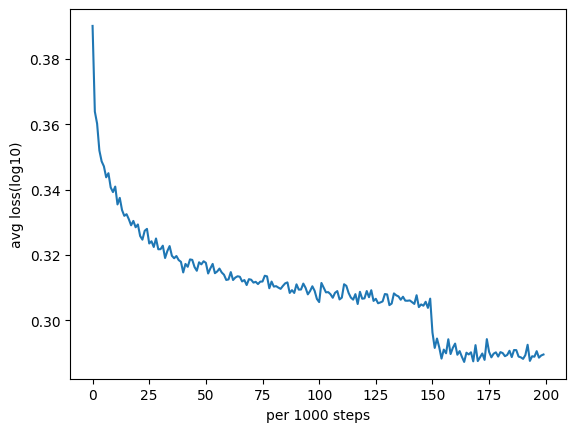

In [8]:
import matplotlib.pyplot as plt

avg_step = 1000
plt.plot(torch.tensor(lossis).view(-1, avg_step).mean(dim=1))
plt.xlabel(f'per {avg_step} steps')
plt.ylabel('avg loss(log10)')
plt.show()




## benchmark

- test loss: 2.2470074159183913 (context length=2)
- test loss: 2.044092865367425 (context length=8)

# wavenet